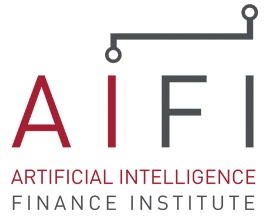


# Bootcamp - Python and Coding - Deep Learning

# Transformer Model

# About this Notebook

This is just one example of using sentences from SDG criteria and extracted sentences from sustainability reports of listed companies to find and classify similarity with a deep learning network. 

To do this, we use a transformer model from SBERT.net, a Python framework for modern sentence, text, and image embedding. The initial work is described in the [paper](https://arxiv.org/abs/1908.10084). We can then use these embeddings to compare these sentences with cosine similarity computation to find sentences with similar meaning, since this library already provides a ready-to-use function util.pytorch_cos_sim.

The framework is based on PyTorch and Transformers and provides a large collection of pre-trained models tuned for different tasks. In addition, it is easy to fine-tune your own models. See the [documentation](https://www.sbert.net/) for more information on using this library.

# Imports

In [1]:
# standard imports
import numpy as np
import pandas as pd
import os

# text processing
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import re, string
import fitz
from sentence_transformers import SentenceTransformer, util

# other useful imports
from importlib import reload
from time import time
from pathlib import Path
from tqdm.notebook import tqdm

# plotting
from pylab import plt, mpl

#ignore warnings
import warnings
warnings.filterwarnings(action='ignore')

# File Paths

In [2]:
DATA_PATH = '../../data/reports'
SDG_PATH = '../../data/sdg.xlsx'
FILE_NAME_SENT = '../../data/sentences.csv'

# Helper Functions

### Get Count of Words

In [3]:
def word_count(text):
    cnt = 0
    for word in text.split():
        if word.isalpha():
            cnt += 1
    return cnt

### Extract Text  from PDF

In [4]:
def generate_text_blocks(block_list, min_word_count=15):
    text_list = []
    for block in block_list:
        # block type -> 0 = text
        if block[6] != 0:
            continue

        text = block[4]

        text = text.replace('Johnson', '')
        text = text.replace('Amazon', '')

        # only extract sentences with more than min_word_count
        if word_count(text) < min_word_count:
            continue

        text_list.append(text.replace('-\n', ''))

    return ('\n'.join(text_list))

In [ ]:
def create_sentence_list(file_name, skip_page=(0,)):

    doc = fitz.open(file_name)

    sent_list = []
    for page_no, page in enumerate(doc):

        # skip page(s) if set
        if page_no+1 in skip_page:
            continue

        # extract text blocks and process them, docu:
        # https://pymupdf.readthedocs.io/en/latest/app1.html?highlight=page.get_text#plain-text
        block_list = page.get_text('blocks', sort=False)
        text = generate_text_blocks(block_list)

        # tokenize sentences: https://www.nltk.org/api/nltk.tokenize.html
        for i, sentence in enumerate(sent_tokenize(text)):
            # remove '\n', '\t'
            sent = ' '.join(sentence.split())
            sent_list.append(sent)

    doc.close()

    return sent_list

### Create Data Frame

In [5]:
def create_df(doc_id, file_name, sent_list):

    df = pd.DataFrame(
        {'doc_id': doc_id,
         'file_name': file_name,
         'sentence': sent_list
         })

    return df

### Define Function: Read PDF file list

In [6]:
def read_files(path):
    # Create empty DataFrame
    df = pd.DataFrame()
    # create doc_id
    doc_id = 0

    # read all files from directory
    for idx, file_name in tqdm(enumerate(os.listdir(path))):
        p_file_name = os.path.join(path, file_name)

        if p_file_name.split('.')[-1] != 'pdf':
            continue
        print('Processing: ', file_name)

        doc_id += 1

        print('Assigning document id: {} '.format(doc_id))
        print('')

        sent_list = create_sentence_list(p_file_name)
        df_doc = create_df(doc_id, file_name, sent_list)

        df = pd.concat([df, df_doc])

    return df

## Plotting

In [7]:
def ordered_compare_plot(data):
    # plot data in stack manner of bar type
    data.plot(x='SDG goal', kind='bar',
              edgecolor="black", linewidth=0.2, figsize=(15, 8))
    
    
    plt.ylabel('Score in %')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.ylim(0, 0.25)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13),
               fancybox=True, shadow=True, ncol=7)

    plt.grid()

In [8]:
# generate list of companies from path
name_list = []
for idx, file_name in enumerate(os.listdir(DATA_PATH)):
    name_list.append(Path(file_name).stem)

In [9]:
# remove hidden file frm list
try: 
    name_list.remove('.DS_Store')
except:
    print("Not on a Mac, can't remove .DS_Store!")
else:
    print("Removed .DS_Store from company list")
    
name_list

Removed .DS_Store from company list


['United Health Group',
 'JPmorgan',
 'P & G',
 'Johnson-Johnson',
 'NVDIA',
 'Broadcom',
 'Meta',
 'Tesla',
 'Microsoft',
 'Apple',
 'Coca-Cola',
 'Google',
 'Exxon',
 'Amazon']

In [10]:
df = read_files(DATA_PATH)

0it [00:00, ?it/s]

Processing:  United Health Group.pdf
Assigning document id: 1 

Processing:  JPmorgan.pdf
Assigning document id: 2 

Processing:  P & G.pdf
Assigning document id: 3 

Processing:  Johnson-Johnson.pdf
Assigning document id: 4 

Processing:  NVDIA.pdf
Assigning document id: 5 

Processing:  Broadcom.pdf
Assigning document id: 6 

Processing:  Meta.pdf
Assigning document id: 7 

Processing:  Tesla.pdf
Assigning document id: 8 

Processing:  Microsoft.pdf
Assigning document id: 9 

Processing:  Apple.pdf
Assigning document id: 10 

Processing:  Coca-Cola.pdf
Assigning document id: 11 

Processing:  Google.pdf
Assigning document id: 12 

Processing:  Exxon.pdf
Assigning document id: 13 

Processing:  Amazon.pdf
Assigning document id: 14 



### Read SDG File & Clean Data

In [11]:
df_sdg = pd.read_excel(SDG_PATH)

In [12]:
df_sdg_doc = df_sdg.groupby('gpname')['sentence'].agg(' '.join).reset_index()

# save the "themes" as list, for later use
sdg_theme_list = df_sdg_doc['gpname'].tolist()


In [13]:
# remove special characters info: https://regex101.com/
regex_match = r'[^a-zA-Z]'
df_sdg['sentence'] = df_sdg['sentence'].str.replace(regex_match,' ', regex=True)

# convert all to lower case
df_sdg = df_sdg.apply(lambda x: x.astype(str).str.lower())

df_sdg

,gpnum,gpname,goalnum,sentence
0,gp01,life,goal01,end poverty in all its forms everywhere
1,gp01,life,goal01,despite progress under the mdgs approximately...
2,gp01,life,goal01,over the past decade markets in developing co...
3,gp01,life,goal01,certain groups are disproportionately represen...
4,gp01,life,goal01,these include women persons with disabilities...
...,...,...,...,...
636,gp06,environments,goal15,take urgent action to end poaching and tr...
637,gp06,environments,goal15,by introduce measures to prevent th...
638,gp06,environments,goal15,by integrate ecosystems and biodive...
639,gp06,environments,goal15,a mobilize and significantly increase from ...


In [14]:
# init transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# process data frames as list 
sdg_sentences = df_sdg['sentence'].tolist()
reports_sentences = df['sentence'].tolist()

# compute embeddings 
embeddings_sdg = model.encode(sdg_sentences, convert_to_tensor=True)
embeddings_reports = model.encode(reports_sentences, convert_to_tensor=True)

# compute cosine-similarity
cosine_scores = util.pytorch_cos_sim(embeddings_sdg, embeddings_reports)

In [15]:
cosine_sim_arr  = np.array(cosine_scores.cpu()).T

In [16]:
sdg_goals = df_sdg['goalnum'].value_counts().sort_index()
sdg_goals

goal01    40
goal02    38
goal03    43
goal04    37
goal05    43
goal06    45
goal07    29
goal08    42
goal09    29
goal10    44
goal11    35
goal12    41
goal13    30
goal14    40
goal15    44
goal16    40
goal17    21
Name: goalnum, dtype: int64

In [17]:
# init
for key in sdg_goals.index:
    df[key] = 0.0

for idx in tqdm(df.index):
    off_b = 0
    off_e = 0
    
    for key in sdg_goals.index:
        off_b = off_e
        off_e += sdg_goals[key]
        df.loc[idx,key] = cosine_sim_arr[idx][off_b:off_e].mean()

  0%|          | 0/12598 [00:00<?, ?it/s]

In [18]:
df.head()

,doc_id,file_name,sentence,goal01,goal02,goal03,goal04,goal05,goal06,goal07,goal08,goal09,goal10,goal11,goal12,goal13,goal14,goal15,goal16,goal17
0,1,United Health Group.pdf,Introduction A message from our CEO A message ...,0.235896,0.199520,0.266893,0.177224,0.257760,0.214584,0.188496,0.210663,0.261766,0.204824,0.243177,0.220734,0.257748,0.245555,0.200719,0.222063,0.187012
1,1,United Health Group.pdf,"At UnitedHealth Group, we believe a healthy po...",0.207957,0.206365,0.237609,0.134319,0.236803,0.183946,0.140241,0.165552,0.273335,0.150690,0.216651,0.188037,0.288877,0.256878,0.197014,0.209454,0.203182
2,1,United Health Group.pdf,"The more than 350,000 people across Optum and ...",0.201863,0.165649,0.279546,0.131096,0.167953,0.156176,0.143068,0.169272,0.193826,0.121127,0.142557,0.139904,0.183883,0.135371,0.119871,0.124189,0.120706
3,1,United Health Group.pdf,Given our reach and resources – and the millio...,0.247797,0.199685,0.301517,0.141523,0.252720,0.193579,0.148825,0.192238,0.270368,0.184259,0.234373,0.199052,0.250189,0.235037,0.188664,0.214435,0.212151
4,1,United Health Group.pdf,That’s what makes a health care system sustain...,0.211621,0.205682,0.294656,0.163138,0.242467,0.188796,0.158189,0.197520,0.225543,0.162897,0.205483,0.201493,0.253745,0.224078,0.176285,0.190528,0.172235


In [19]:
sdg_list = pd.read_excel(SDG_PATH)

In [20]:
category_list = sdg_list.gpname.to_list()
goals_list = sdg_list.goalnum.to_list()

categories_dict = {}
for key in goals_list:
    for value in category_list:
        categories_dict[key] = value
        category_list.remove(value)
        break  

In [21]:
categories_dict

{'goal01': 'Life',
 'goal02': 'Life',
 'goal03': 'Life',
 'goal08': 'Economic and Technological Development',
 'goal09': 'Economic and Technological Development',
 'goal04': 'Equity',
 'goal05': 'Equity',
 'goal10': 'Equity',
 'goal11': 'Social Development',
 'goal16': 'Social Development',
 'goal17': 'Social Development',
 'goal06': 'Resources',
 'goal07': 'Resources',
 'goal12': 'Resources',
 'goal14': 'Resources',
 'goal13': 'Environments',
 'goal15': 'Environments'}

In [22]:
cat_list = [*set(sdg_list.gpname.to_list())]
cat_list

['Social Development',
 'Resources',
 'Economic and Technological Development',
 'Life',
 'Equity',
 'Environments']

In [23]:
df['company'] = df['file_name'].str.split('.').apply(lambda x: x[0])

In [24]:
# get list of companies
companies_list = df['company'].unique().tolist()

In [25]:
df_companies = df.groupby(['company']).mean()
df_companies.drop('doc_id', axis=1, inplace=True)

In [26]:
df_companies_T = df_companies.T.copy()
df_companies_T.reset_index(inplace=True)

df_companies_T

company,index,Amazon,Apple,Broadcom,Coca-Cola,Exxon,Google,JPmorgan,Johnson-Johnson,Meta,Microsoft,NVDIA,P & G,Tesla,United Health Group
0,goal01,0.144490,0.144811,0.150579,0.148858,0.150769,0.167729,0.152211,0.136696,0.162128,0.142056,0.147925,0.161870,0.146474,0.147901
1,goal02,0.129587,0.130719,0.120753,0.129937,0.121108,0.146464,0.118220,0.123880,0.133256,0.128497,0.129837,0.146128,0.129175,0.125983
2,goal03,0.157913,0.159676,0.195069,0.165620,0.194389,0.199696,0.201267,0.158146,0.203740,0.159885,0.171893,0.191786,0.160872,0.178019
3,goal04,0.112778,0.112567,0.101941,0.115472,0.102607,0.120757,0.100764,0.105216,0.110932,0.109892,0.110793,0.117502,0.114343,0.108602
4,goal05,0.165702,0.167107,0.153223,0.167989,0.153951,0.181342,0.148179,0.159765,0.166626,0.164612,0.164916,0.184974,0.166593,0.158498
5,goal06,0.143526,0.144081,0.132919,0.148701,0.133865,0.156736,0.133387,0.135746,0.146699,0.141178,0.144460,0.155043,0.146568,0.144182
6,goal07,0.119759,0.120161,0.109226,0.122219,0.109628,0.129283,0.110154,0.112307,0.120760,0.117430,0.119664,0.124183,0.121470,0.120835
7,goal08,0.144851,0.144929,0.137117,0.147901,0.137206,0.157386,0.138208,0.136005,0.148939,0.141725,0.144238,0.153343,0.146977,0.142829
8,goal09,0.150243,0.151269,0.147527,0.152696,0.148166,0.169324,0.139538,0.142906,0.158066,0.148425,0.152510,0.173212,0.151144,0.145468
9,goal10,0.132403,0.133399,0.114466,0.132933,0.114865,0.138454,0.112611,0.125147,0.126990,0.130678,0.132148,0.140819,0.133295,0.131315


In [27]:
# map the dictonary
df_companies_T['category'] = df_companies_T['index'].map(categories_dict)
df_companies_T.head()

company,index,Amazon,Apple,Broadcom,Coca-Cola,Exxon,Google,JPmorgan,Johnson-Johnson,Meta,Microsoft,NVDIA,P & G,Tesla,United Health Group,category
0,goal01,0.144490,0.144811,0.150579,0.148858,0.150769,0.167729,0.152211,0.136696,0.162128,0.142056,0.147925,0.161870,0.146474,0.147901,Life
1,goal02,0.129587,0.130719,0.120753,0.129937,0.121108,0.146464,0.118220,0.123880,0.133256,0.128497,0.129837,0.146128,0.129175,0.125983,Life
2,goal03,0.157913,0.159676,0.195069,0.165620,0.194389,0.199696,0.201267,0.158146,0.203740,0.159885,0.171893,0.191786,0.160872,0.178019,Life
3,goal04,0.112778,0.112567,0.101941,0.115472,0.102607,0.120757,0.100764,0.105216,0.110932,0.109892,0.110793,0.117502,0.114343,0.108602,Equity
4,goal05,0.165702,0.167107,0.153223,0.167989,0.153951,0.181342,0.148179,0.159765,0.166626,0.164612,0.164916,0.184974,0.166593,0.158498,Equity


In [28]:
# rename column
df_companies_T = df_companies_T.rename(columns={'index': 'SDG goal'})

# reorder data frame
df_companies_T.insert(0, 'category', df_companies_T.pop('category'))

df_companies_T

company,category,SDG goal,Amazon,Apple,Broadcom,Coca-Cola,Exxon,Google,JPmorgan,Johnson-Johnson,Meta,Microsoft,NVDIA,P & G,Tesla,United Health Group
0,Life,goal01,0.144490,0.144811,0.150579,0.148858,0.150769,0.167729,0.152211,0.136696,0.162128,0.142056,0.147925,0.161870,0.146474,0.147901
1,Life,goal02,0.129587,0.130719,0.120753,0.129937,0.121108,0.146464,0.118220,0.123880,0.133256,0.128497,0.129837,0.146128,0.129175,0.125983
2,Life,goal03,0.157913,0.159676,0.195069,0.165620,0.194389,0.199696,0.201267,0.158146,0.203740,0.159885,0.171893,0.191786,0.160872,0.178019
3,Equity,goal04,0.112778,0.112567,0.101941,0.115472,0.102607,0.120757,0.100764,0.105216,0.110932,0.109892,0.110793,0.117502,0.114343,0.108602
4,Equity,goal05,0.165702,0.167107,0.153223,0.167989,0.153951,0.181342,0.148179,0.159765,0.166626,0.164612,0.164916,0.184974,0.166593,0.158498
5,Resources,goal06,0.143526,0.144081,0.132919,0.148701,0.133865,0.156736,0.133387,0.135746,0.146699,0.141178,0.144460,0.155043,0.146568,0.144182
6,Resources,goal07,0.119759,0.120161,0.109226,0.122219,0.109628,0.129283,0.110154,0.112307,0.120760,0.117430,0.119664,0.124183,0.121470,0.120835
7,Economic and Technological Development,goal08,0.144851,0.144929,0.137117,0.147901,0.137206,0.157386,0.138208,0.136005,0.148939,0.141725,0.144238,0.153343,0.146977,0.142829
8,Economic and Technological Development,goal09,0.150243,0.151269,0.147527,0.152696,0.148166,0.169324,0.139538,0.142906,0.158066,0.148425,0.152510,0.173212,0.151144,0.145468
9,Equity,goal10,0.132403,0.133399,0.114466,0.132933,0.114865,0.138454,0.112611,0.125147,0.126990,0.130678,0.132148,0.140819,0.133295,0.131315


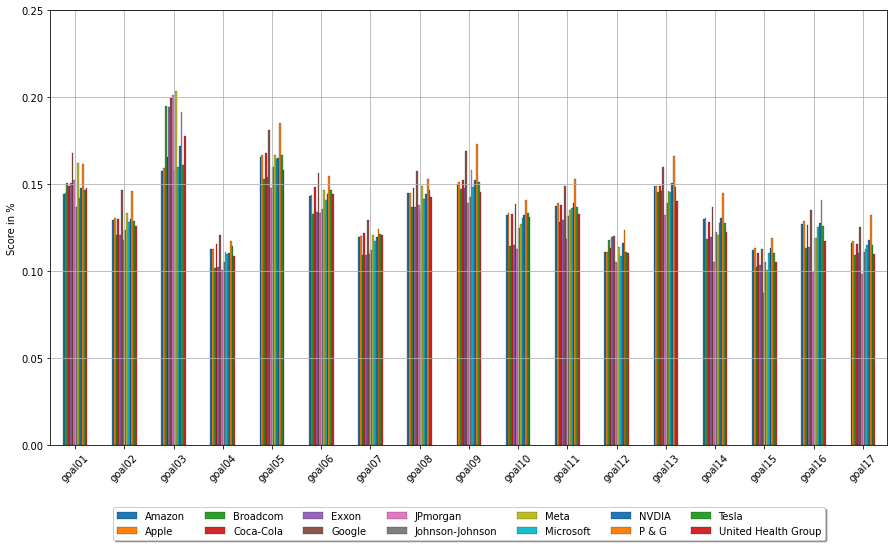

In [29]:
ordered_compare_plot(df_companies_T)